 - load data (pd.datetime)
 - describe data (pd.describe, na data, Augmented Dickey–Fuller test with statsmodels.tsa.stattools.adfuller)
 - plot data clearly with rolling mean and std
 - feature engineering if necessary
 - if unbalanced features sklearn.preprocessing.StandardScaler().fit_transform(X)
 - detect outlier:
    - DBSCAN
    - K-means
    - MAD
    - OneClassSVM

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import graphics, acf, pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import datetime
from tqdm import tqdm

In [3]:
# path = "./data/archive/realKnownCause/realKnownCause/ec2_request_latency_system_failure.csv"
# path = "./data/archive/realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv"
# path = "./data/archive/realKnownCause/realKnownCause/cpu_utilization_asg_misconfiguration.csv"
path = "./data/archive/artificialWithAnomaly/artificialWithAnomaly/art_daily_jumpsup.csv"


In [4]:
data = pd.read_csv(
    path,
    index_col=0
)
data.index = pd.to_datetime(data.index)
# data = data.asfreq('5MIN').dropna()

<Axes: xlabel='timestamp'>

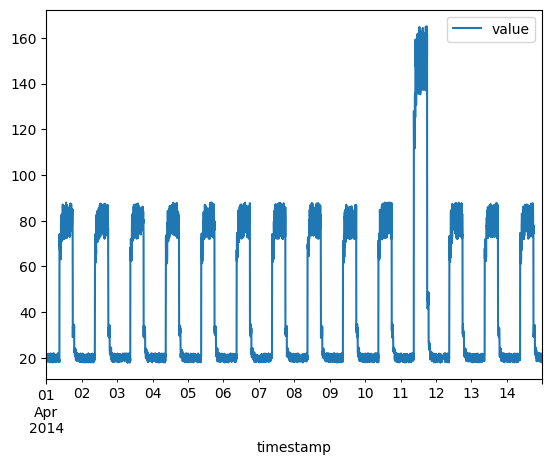

In [5]:
data.plot()

In [6]:
data.describe()

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


In [7]:
data.isna().mean()

value    0.0
dtype: float64

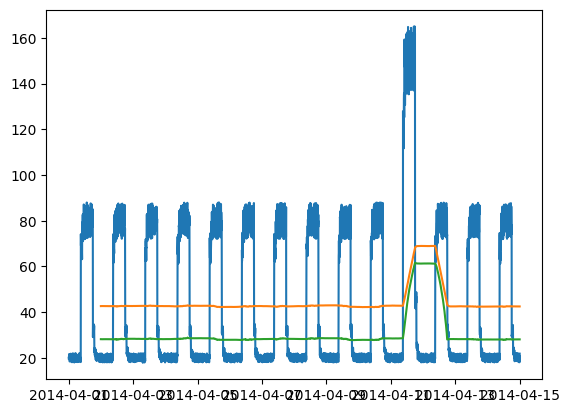

In [8]:
plt.plot(data)
plt.plot(data.rolling(window=288).mean().dropna())
plt.plot(data.rolling(window=288).std().dropna())

In [9]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = statsmodels.tsa.stattools.adfuller(data, autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -5.908387e+00
p-value                        2.674749e-07
#Lags Used                     1.700000e+01
Number of Observations Used    4.014000e+03
Critical Value (1%)           -3.431980e+00
Critical Value (5%)           -2.862260e+00
Critical Value (10%)          -2.567153e+00
dtype: float64


In [18]:
dec = seasonal_decompose(data['value'], period=288)

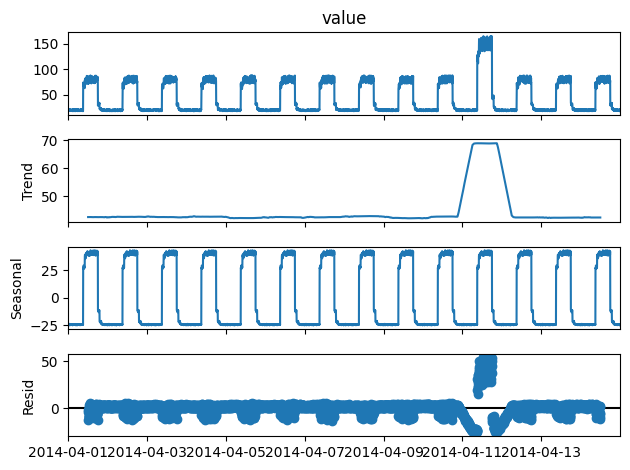

In [19]:
dec.plot()
plt.show()

### daily profile

In [20]:
data["weekday"] = data.index.weekday
data["hour"] = data.index.hour

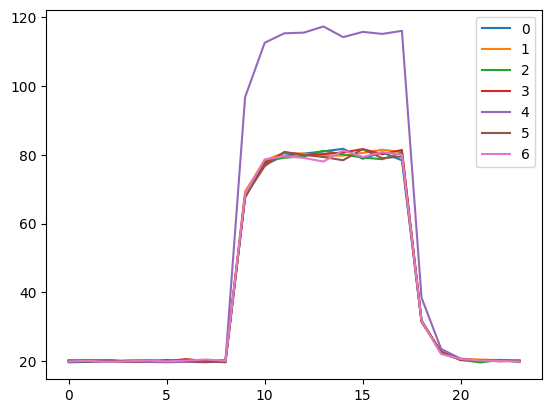

In [21]:
# Daily profile resampled to 1 hour
for day in range(7):
    plt.plot(data.where(data["weekday"]==day).groupby("hour").mean()["value"].dropna().values, label=day)
plt.legend()

## detect outliers

### MAD

In [22]:
data.drop(["hour", "weekday"], axis=1, inplace=True, errors='ignore')

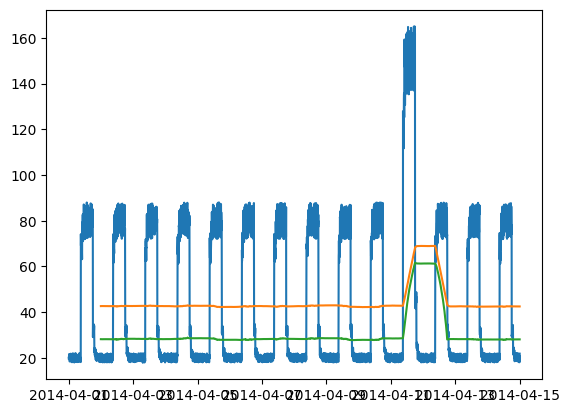

In [23]:
plt.plot(data)
plt.plot(data.rolling(window=288).mean().dropna())
plt.plot(data.rolling(window=288).std().dropna())

In [24]:
window = 288
med = np.median(data.values)
mad = np.array([np.median(abs(data.values[abs(idx - window // 2): idx + window // 2] - med)) for idx in range(len(data))])

/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


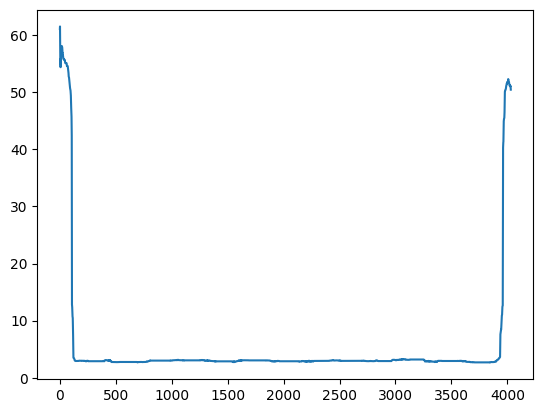

In [25]:
plt.plot(mad)

In [30]:
tolerence = 25
mask = abs(data.values.T[0] - med) > mad * tolerence

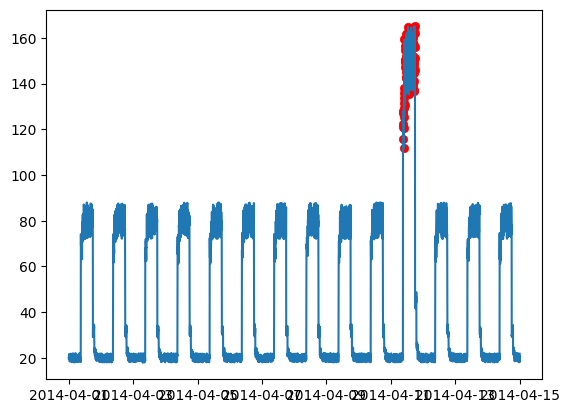

In [31]:
plt.plot(data)
plt.scatter(data.index[mask], data.values[mask].T[0], c="r", lw=.5)

### clustering : dbscan

In [32]:
from  sklearn.cluster import DBSCAN

In [33]:
# scaled_data = StandardScaler().fit_transform(data)

In [34]:
def euclidean(x, y):
    return np.sqrt(np.sum(np.square(x - y)))

In [35]:
med = np.median(data.value)
# eps = np.median(abs(data.value - med))
eps = np.median([euclidean(x, med) for x in data.value])
tolerance = 5

In [36]:
cluster = DBSCAN(eps=tolerance * eps, min_samples=int(len(data.value) * 0.1))

In [37]:
cluster.fit(data)
labels = cluster.labels_

In [38]:
print(f"Number of clusters = {len(set(labels) - set([-1]))}")

Number of clusters = 2


In [39]:
np.unique(labels, return_counts=True)

(array([-1,  0,  1]), array([ 108, 2520, 1404]))

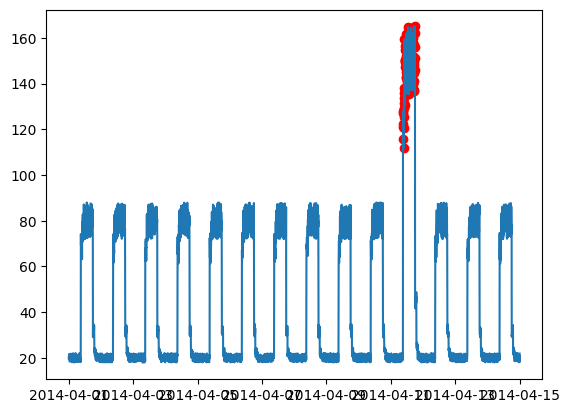

In [40]:
mask = labels == -1
plt.plot(data)
plt.scatter(data.index[mask], data.values[mask].T[0], c="r")

### clustering : kmeans

In [41]:
from sklearn.cluster import KMeans

In [42]:
kmeans_instance = [KMeans(n_clusters=i).fit(data) for i in range(1, 8)]

/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/sklearn/

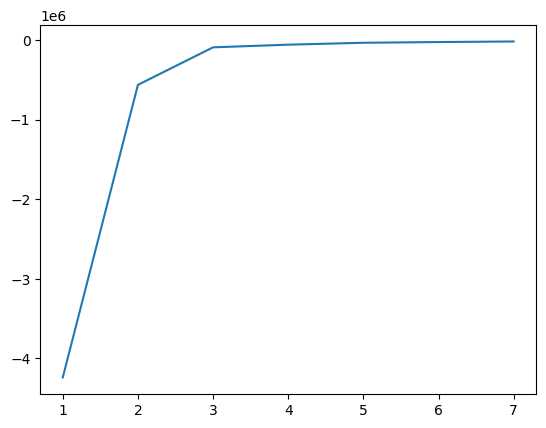

In [43]:
plt.plot(range(1, 8), [kmeans_instance[i].score(data) for i in range(7)])

##### detect outlier as a stand alone class

In [48]:
kmeans_instance = KMeans(n_clusters=2).fit(data)

/home/ghassene/.virtualenvs/outlier_detection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [49]:
kmeans_instance.score(data)

-564921.3423464587

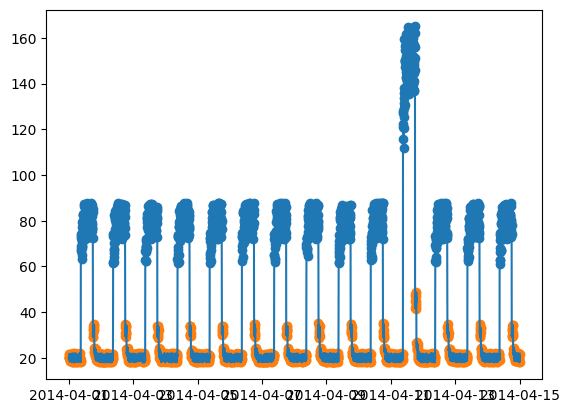

In [50]:
plt.plot(data)
for label in set(kmeans_instance.labels_):
    plt.scatter(data.index[kmeans_instance.labels_==label], data.value[kmeans_instance.labels_==label])

In [51]:
kmeans_instance.cluster_centers_

array([[83.47063454],
       [21.10842593]])

##### detect outlier as points far from built clusters

In [54]:
min_distance = kmeans_instance.transform(data).min(axis=1)

In [60]:
window = 288
med = np.median(data.values)
mad = np.array([np.median(abs(min_distance[max(0, idx - window // 2): idx + window // 2] - med)) for idx in range(len(min_distance))])

In [70]:
tolerence = 4
mask = abs(data.values.T[0] - med) > mad * tolerence

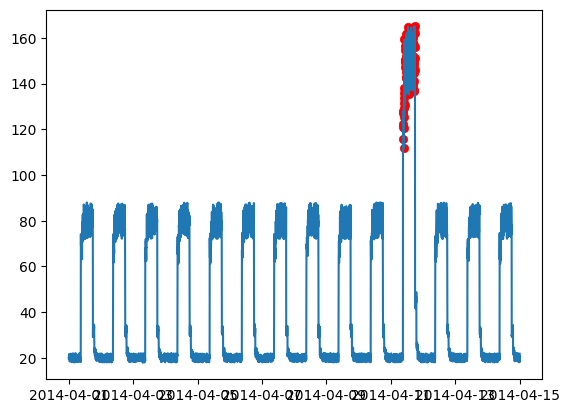

In [71]:
plt.plot(data)
plt.scatter(data.index[mask], data.values[mask].T[0], c="r", lw=.5)

### Unsupervised : OneClassSVM

In [40]:
one_class = OneClassSVM()
one_class.fit(data)

OneClassSVM()

In [41]:
labels = one_class.predict(data)

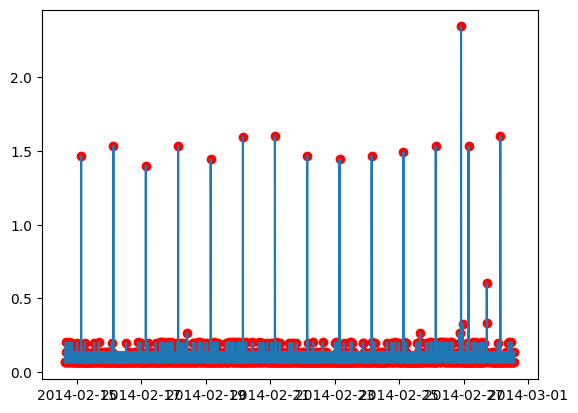

In [42]:
mask = labels == -1
plt.plot(data)
plt.scatter(data.index[mask], data.values[mask].T[0], c="r")

### IsolationForest: ensemble

In [43]:
from sklearn.ensemble import IsolationForest

In [44]:
iso_forest = IsolationForest(n_estimators=100)
iso_forest.fit(data)

IsolationForest()

In [45]:
labels = iso_forest.predict(data)

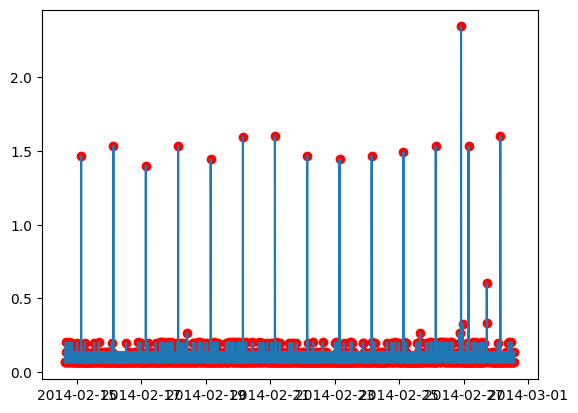

In [46]:
mask = labels == -1
plt.plot(data)
plt.scatter(data.index[mask], data.values[mask].T[0], c="r")

In [39]:
from sklearn.svm import OneClassSVM